# Google Merchandise Store Analysis: 


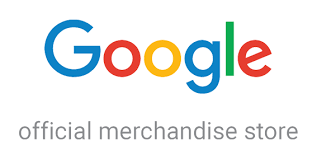


In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
pd.set_option('display.max_columns', None)

import json
from pandas.io.json import json_normalize
%matplotlib inline

/kaggle/input/ga-customer-revenue-prediction/sample_submission.csv
/kaggle/input/ga-customer-revenue-prediction/train_v2.csv
/kaggle/input/ga-customer-revenue-prediction/test_v2.csv
/kaggle/input/ga-customer-revenue-prediction/sample_submission_v2.csv
/kaggle/input/ga-customer-revenue-prediction/train.csv
/kaggle/input/ga-customer-revenue-prediction/test.csv


In [2]:
file_path='../input/ga-customer-revenue-prediction/train.csv'
def load_df(csv_path=file_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
train = load_df(file_path,100000)

Loaded train.csv. Shape: (100000, 55)


In [4]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [5]:
#check data type
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    100000 non-null  object
 1   date                                               100000 non-null  int64 
 2   fullVisitorId                                      100000 non-null  object
 3   sessionId                                          100000 non-null  object
 4   socialEngagementType                               100000 non-null  object
 5   visitId                                            100000 non-null  int64 
 6   visitNumber                                        100000 non-null  int64 
 7   visitStartTime                                     100000 non-null  int64 
 8   device.browser                                     100000 non-null  object
 9   devic

In [6]:
np.random.seed(2021)

visitors = train['fullVisitorId'].unique()
selected_visitors = np.random.choice(visitors, size = int(visitors.shape[0] * 0.1), replace = False)

df = train[train['fullVisitorId'].isin(selected_visitors)]

In [7]:
print(f"Number of visitId equal to visitStartTime = {(df['visitId'] == df['visitStartTime']).sum()}")

Number of visitId equal to visitStartTime = 9999


In [8]:
# check constant column 
total = 0
lst = {}
for i in df.columns:
    if df[i].nunique() ==1:
        lst[i] = df[i].unique()[0]
        total += 1
print(f'Number of columns with only one value = {total}')
uni = pd.DataFrame.from_dict(lst,orient='index',columns=['unique_var'])
uni

Number of columns with only one value = 25


,unique_var
socialEngagementType,Not Socially Engaged
device.browserVersion,not available in demo dataset
device.browserSize,not available in demo dataset
device.operatingSystemVersion,not available in demo dataset
device.mobileDeviceBranding,not available in demo dataset
device.mobileDeviceModel,not available in demo dataset
device.mobileInputSelector,not available in demo dataset
device.mobileDeviceInfo,not available in demo dataset
device.mobileDeviceMarketingName,not available in demo dataset
device.flashVersion,not available in demo dataset


In [9]:
# drop the columns with only one unique string 
# since it will not provide useful information for us to predict the revenue.
# The continuos varibeles:totals.visits, totals.bounce and totals.newVisits,maybe useful when aggregating the data
uni.drop(['totals.visits','totals.bounces','totals.newVisits'],axis=0,inplace=True)
df.drop([i for i in uni.index],axis=1,inplace=True)
# reset index
df.reset_index(drop=True, inplace=True)
df.head(5)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,1,1,1,NaN,(not set),google,organic,google + online,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,9499785259412240342,9499785259412240342_1472812272,1472812272,1,1472812272,Firefox,Windows,False,desktop,Europe,Western Europe,Netherlands,not available in demo dataset,not available in demo dataset,not available in demo dataset,chello.nl,1,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,1438082600262726746,1438082600262726746_1472803483,1472803483,1,1472803483,Safari,iOS,True,mobile,Asia,Southern Asia,Pakistan,Sindh,(not set),Karachi,unknown.unknown,1,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,9638207207743070032,9638207207743070032_1472824614,1472824614,1,1472824614,Chrome,Macintosh,False,desktop,Asia,Eastern Asia,China,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,1,1,1,NaN,(not set),baidu,organic,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
for col in df.columns:
    print(f'{col} : {df[col].nunique()}')

channelGrouping : 7
date : 40
fullVisitorId : 8921
sessionId : 10049
visitId : 10031
visitNumber : 82
visitStartTime : 10030
device.browser : 23
device.operatingSystem : 12
device.isMobile : 2
device.deviceCategory : 3
geoNetwork.continent : 6
geoNetwork.subContinent : 22
geoNetwork.country : 135
geoNetwork.region : 185
geoNetwork.metro : 40
geoNetwork.city : 232
geoNetwork.networkDomain : 1521
totals.visits : 1
totals.hits : 93
totals.pageviews : 75
totals.bounces : 1
totals.newVisits : 1
totals.transactionRevenue : 121
trafficSource.campaign : 7
trafficSource.source : 65
trafficSource.medium : 6
trafficSource.keyword : 103
trafficSource.referralPath : 174
trafficSource.adwordsClickInfo.slot : 2
trafficSource.adwordsClickInfo.gclId : 225
trafficSource.adContent : 19
trafficSource.campaignCode : 0


## Summary of the Data Type:
* ####  Categorical:
 *  channelGrouping
 * device. - browser, operatingSystem, deviceCategory, isMobile
 * geoNetwork.
 * trafficSource. - campaign, source, medium, adwordsClickInfo.slot, adwordsClickInfo.adNetworkType, adwordsClickInfo.page, adContent
* ####  String:
 * fullVisitorId
 * sessionId
 * trafficSource. - keyword, referralPath, adwordsClickInfo.gclId
*  #### Numeric:
 * visitNumber
 * totals. - hits, pageviews, transactionRevenue, visits, bounces, newVisits
 * Date:
 * date
 * visitId
 * visitStartTime

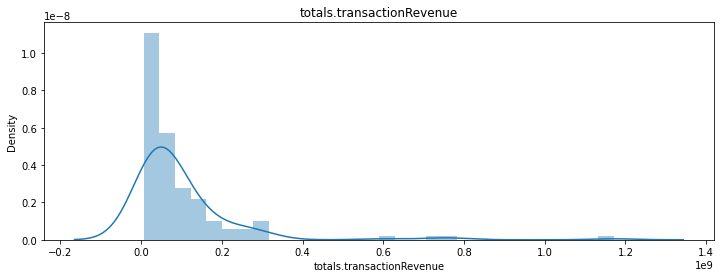

In [11]:
# Target variable
def plot_numeric(feature_name,bins=30):
    fig = plt.figure(figsize= (12, 4))
    sns.distplot(df[feature_name],bins=bins)
    plt.title(feature_name)
    
# convert dtype of target variable to float
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].astype(float)

plot_numeric('totals.transactionRevenue')
# Highly skewed

 Number of transcations with revenue > zero =  130
 Proportion = 1.294%
 Number of unique customers with revenue > zero =  127
 Proportion =  1.424%


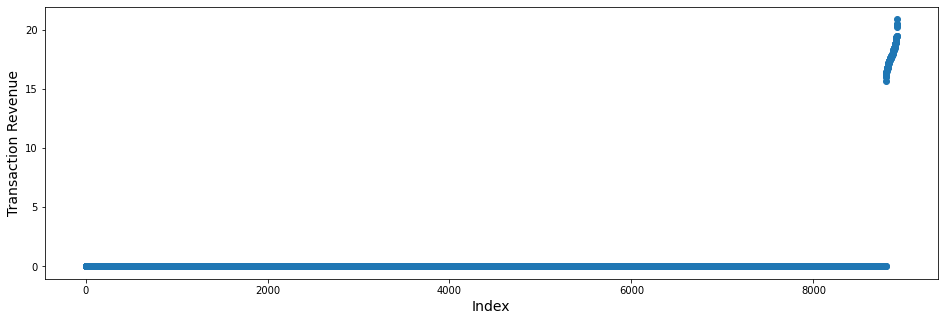

In [12]:
revenue = df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
plt.figure(figsize=(16,5))
plt.scatter(range(revenue.shape[0]), np.sort(np.log1p(revenue['totals.transactionRevenue'].values)))
plt.xlabel('Index', fontsize=14)
plt.ylabel('Transaction Revenue', fontsize=14)

# 80/20 rule holds. But much less than 20.

print(f" Number of transcations with revenue > zero =  {(df['totals.transactionRevenue']>0).sum()}")
print(f" Proportion = {round(((df['totals.transactionRevenue']>0).sum())/len(df)*100,3)}%")
print(f" Number of unique customers with revenue > zero =  {(revenue['totals.transactionRevenue']>0).sum()}")
print(f" Proportion =  {round(((revenue['totals.transactionRevenue']>0).sum())/len(revenue)*100,3)}%")

top 20% customers contribute 61.23544565594812% of total revenue


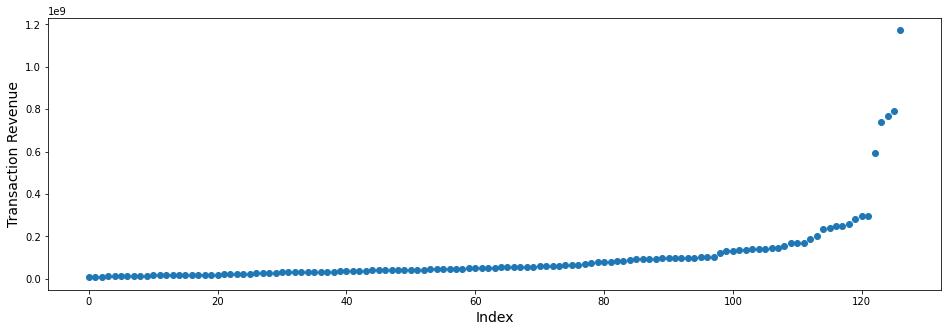

In [13]:
# check if 20% of customers with revenue>0 contributes 80% of revenue
revenue2=revenue[revenue['totals.transactionRevenue']>0].reset_index(drop=True)
plt.figure(figsize=(16,5))
plt.scatter(range(revenue2.shape[0]), np.sort((revenue2['totals.transactionRevenue'].values)))
plt.xlabel('Index', fontsize=14)
plt.ylabel('Transaction Revenue', fontsize=14)

top_20=round(len(revenue2)*0.2)
top_20_revenue=-np.sort(-revenue2['totals.transactionRevenue'].values)[0:top_20].sum()
total_revenue=revenue2['totals.transactionRevenue'].values.sum()

print(f"top 20% customers contribute {top_20_revenue/total_revenue*100}% of total revenue")
#top 20% customers with revenue>0 only contribute ~70% of total revenue

### We can observe that the revenue is not normaally distributed.
#### -> try log-transformation


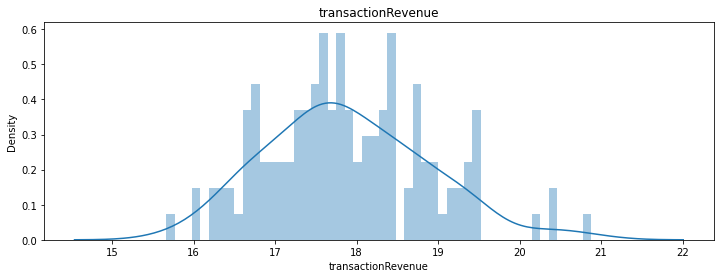

In [14]:
# Our target
df['transactionRevenue'] = np.log1p(df['totals.transactionRevenue'])
# after log-transformation, it is more normally-distribued
plot_numeric('transactionRevenue',bins=50)

In [15]:
df['transactionRevenue'].describe()

count    130.000000
mean      17.883484
std        0.994463
min       15.667110
25%       17.215999
50%       17.797766
75%       18.439975
max       20.881525
Name: transactionRevenue, dtype: float64

In [16]:
# 3. What is the range of the dates in the dataset?

# format the date column
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") 

df["date"].agg(['max','min'])
# This dataset ranges from 2016-08-01 to 2017-08-1

max   2017-08-01
min   2016-08-11
Name: date, dtype: datetime64[ns]

In [17]:
# create month, day, weekday columns
df['visit_month'] = df["date"].dt.month
df['visit_day'] = df["date"].dt.day
df['visit_weekday'] = df["date"].apply(lambda x: x.weekday()+1)
df['visit_weekday'] = df['visit_weekday'].map({1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat',7:'Sun'})

# extract the visit starting hour from visitStartTime
df['visit_hour'] = df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour)).astype(int)
df.drop(['visitStartTime'],axis=1,inplace=True)
# Distribution of visit based on the date


def plot_date(feature_name,order=None):
    dist = df[feature_name].value_counts().to_frame('count')
    dist.reset_index(inplace = True)
    fig = plt.figure(figsize= (16, 5))
    sns.barplot(data = dist, x = 'index', y = 'count',order=order,color='lightblue')
    plt.title(feature_name)

for date in ['visit_month','visit_day','visit_weekday','visit_hour']:
    order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'] if date == 'visit_weekday' else None
    plot_date(date,order=order)

# Categorical Distribution

In [18]:
def plot_categorical(feature_name,limit=15,rotation=0):
    dist = df[feature_name].value_counts(normalize=True).to_frame('proportion') 
    # normalize to obtain the proportion of each category
    dist.reset_index(inplace = True)
    
    if dist.shape[0] > limit: # show the top 15 if not specify
        dist = dist[:limit]

    fig = plt.figure(figsize= (16, 5))
    sns.barplot(data = dist, x = 'index', y = 'proportion', palette="dark")
    plt.title(feature_name)
    #plt.xticks(rotation=45)
    plt.limit=7

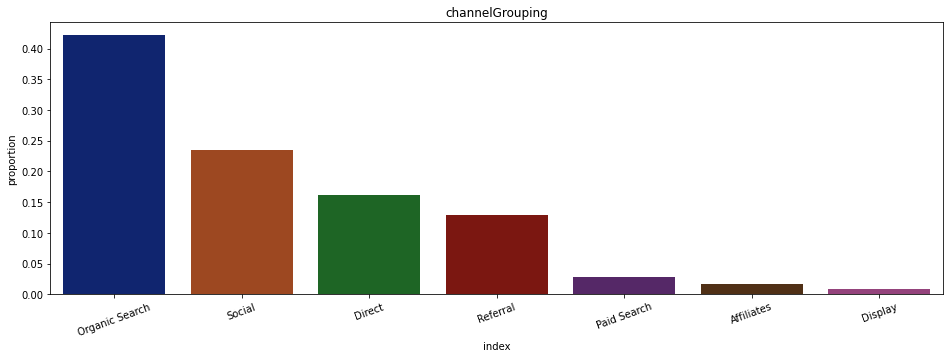

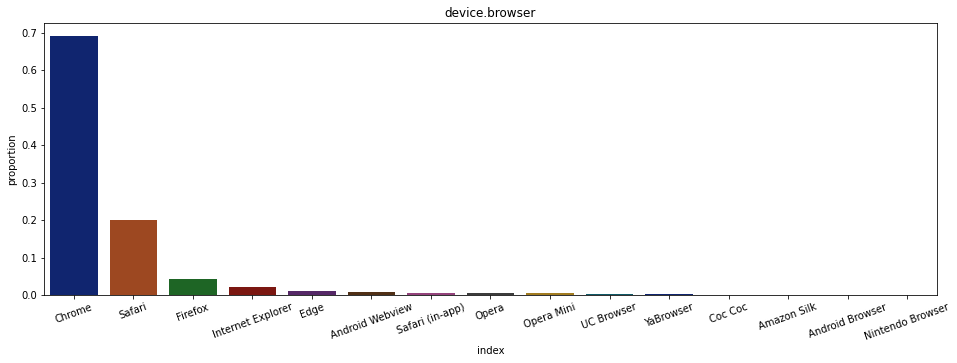

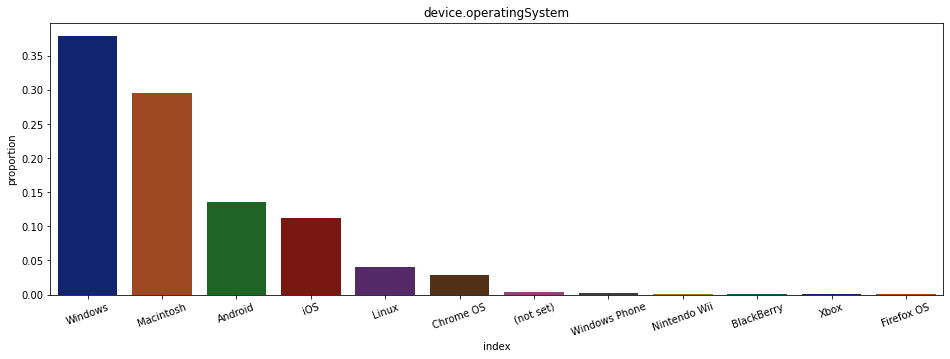

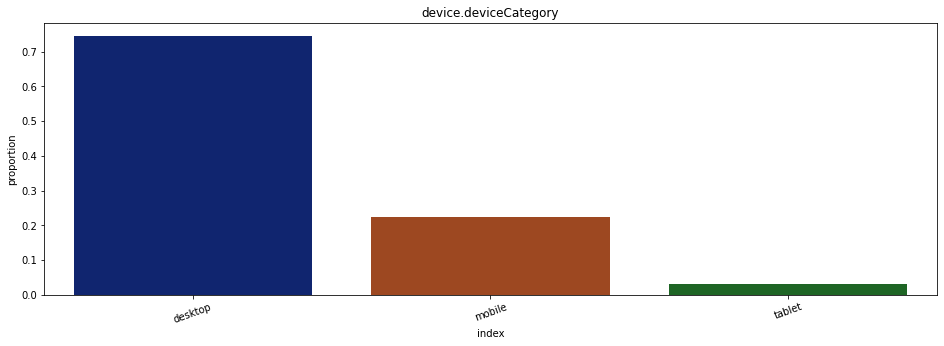

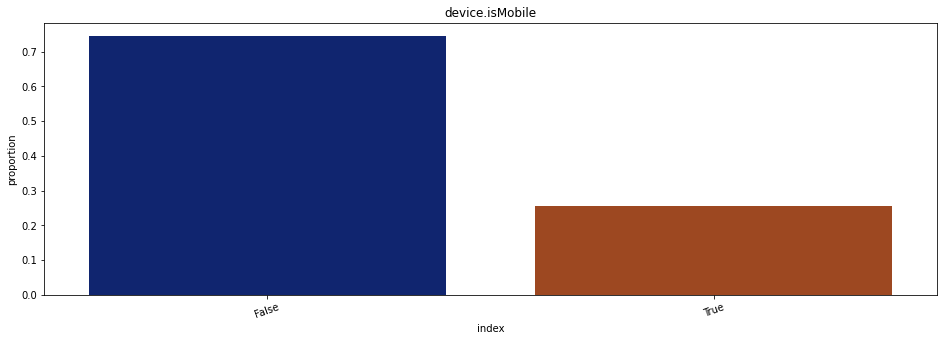

In [19]:
cat = ['channelGrouping','device.browser','device.operatingSystem','device.deviceCategory','device.isMobile']

for category in cat:
    plot_categorical(category)
    plt.xticks(rotation=20)


### Observations:
* 1. Organic Search is the highest, followed by Social and Driect.
* 2. Chrome and Safari are accounted for nearly 90% of the visits.
* 3. Microsoft and Apple dominate the operating system
* 4. Nearly 70% of visit are from desktop.
 * Only 2x% are from mobile

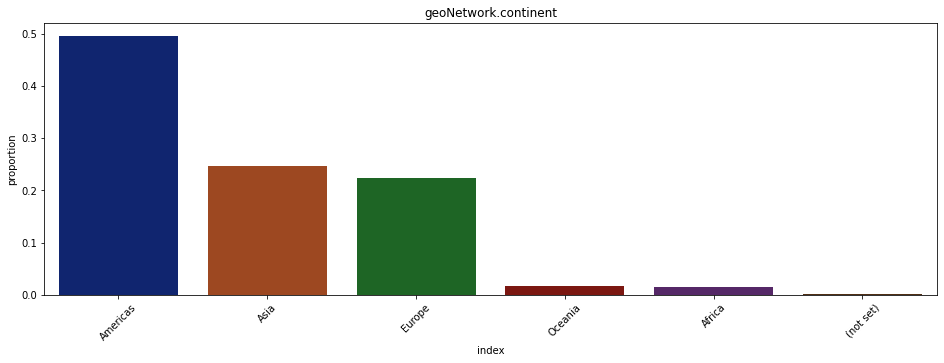

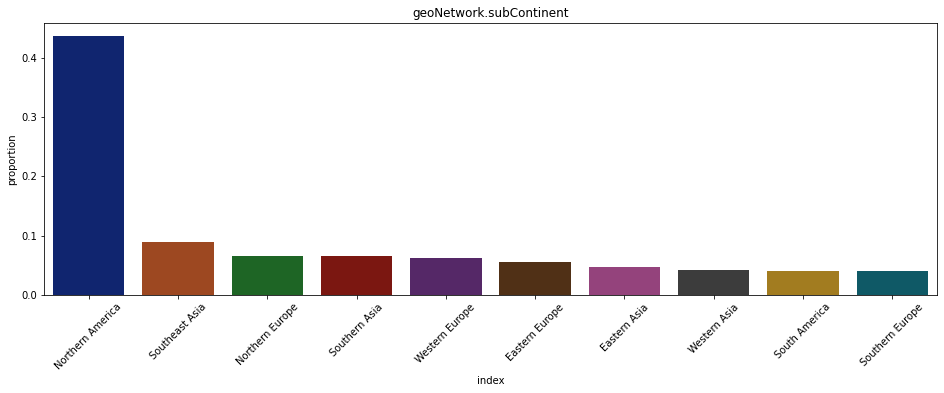

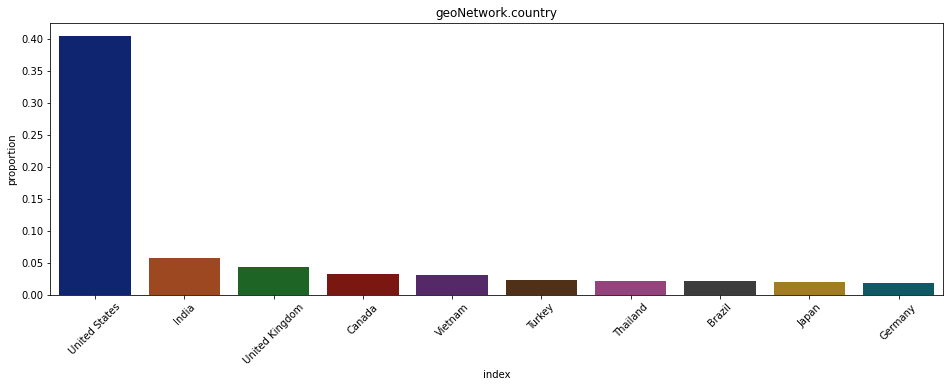

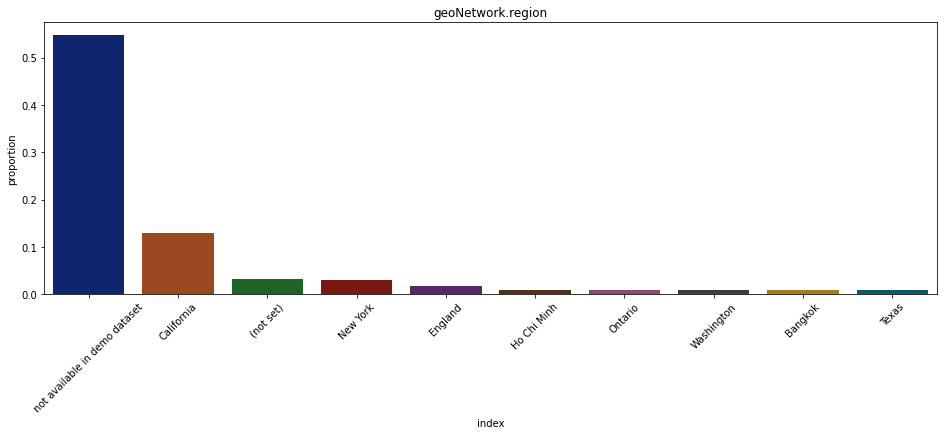

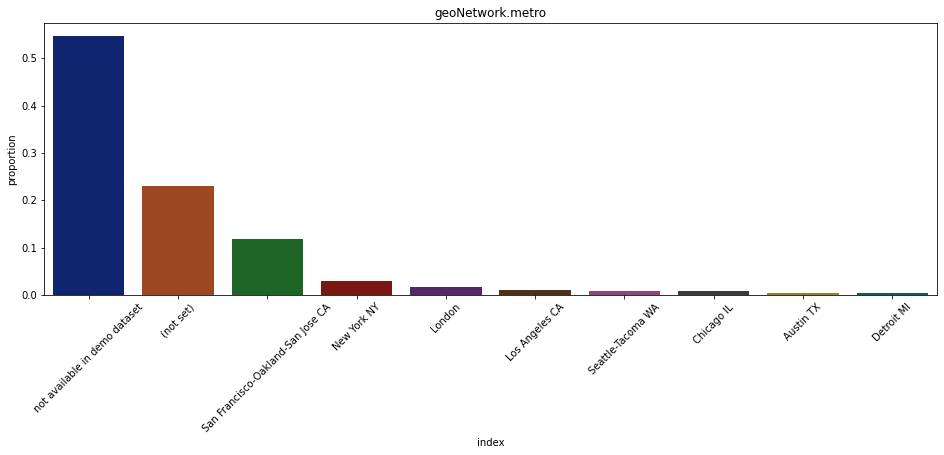

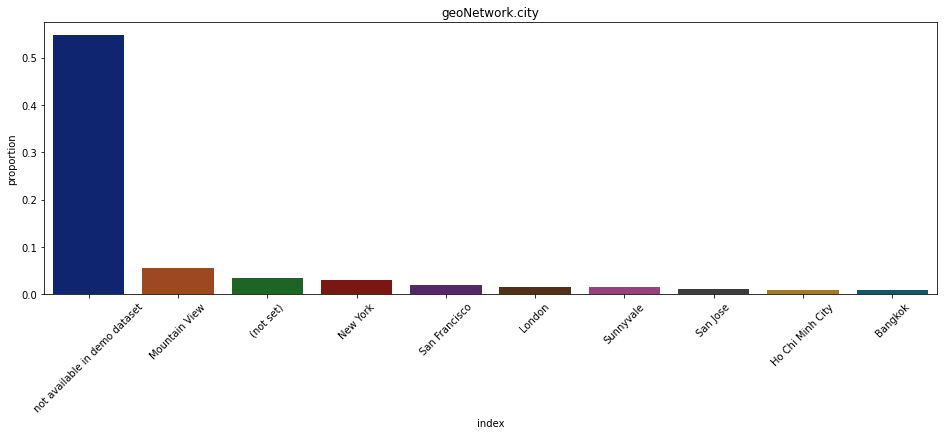

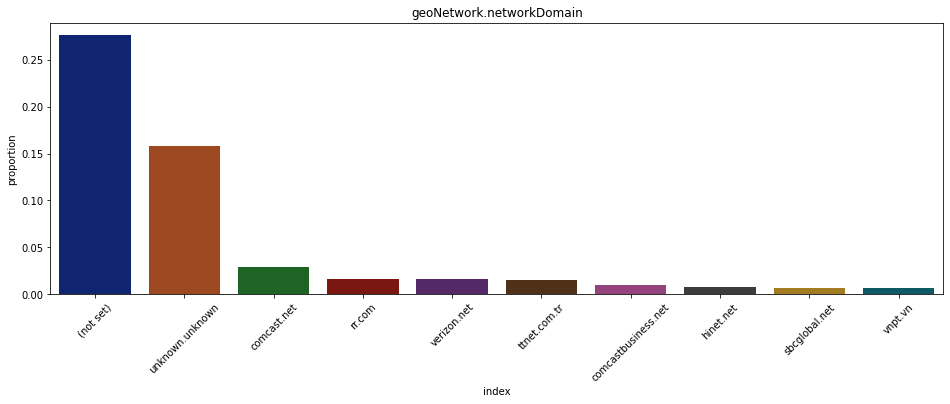

In [20]:
for col in [i for i in df.columns if 'geoNetwork' in i]:
    plot_categorical(col,limit=10)
    plt.xticks(rotation=45)

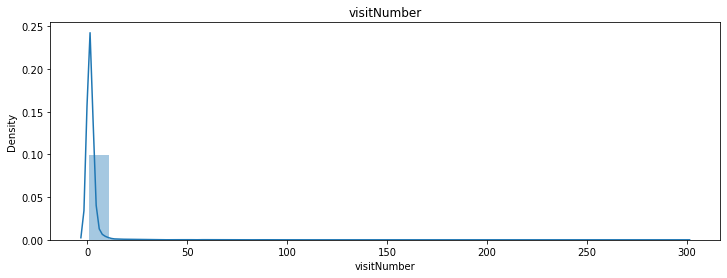

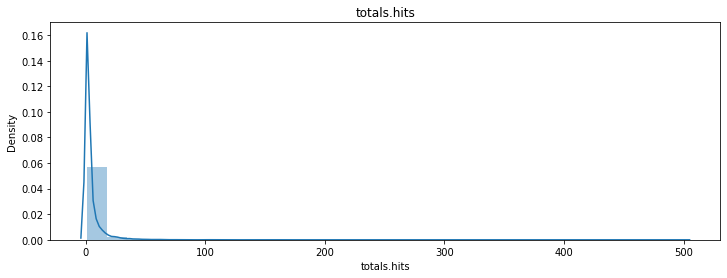

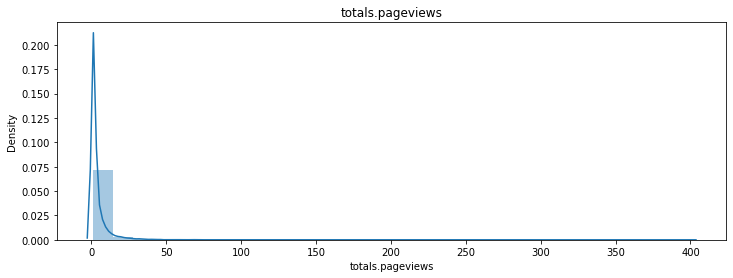

In [21]:
numeric = ['visitNumber','totals.hits','totals.pageviews']
for data in numeric:  
    plot_numeric(data)

### Observations:

* #### These three numeric variable are all highly right-skewed.
* #### Majority of these feature are 1.

In [22]:
df.corr()

,visitId,visitNumber,device.isMobile,totals.transactionRevenue,transactionRevenue,visit_month,visit_day,visit_hour
visitId,1.000000,-0.015587,0.157889,0.025165,0.055247,-0.492517,-0.070764,0.015431
visitNumber,-0.015587,1.000000,-0.053050,0.183457,0.168837,0.000055,-0.026233,0.044366
device.isMobile,0.157889,-0.053050,1.000000,-0.098525,-0.129394,-0.107051,-0.049039,-0.013577
totals.transactionRevenue,0.025165,0.183457,-0.098525,1.000000,0.781481,-0.108506,-0.163341,0.083571
transactionRevenue,0.055247,0.168837,-0.129394,0.781481,1.000000,-0.115727,-0.162558,0.055157
visit_month,-0.492517,0.000055,-0.107051,-0.108506,-0.115727,1.000000,0.098858,-0.035820
visit_day,-0.070764,-0.026233,-0.049039,-0.163341,-0.162558,0.098858,1.000000,-0.029796
visit_hour,0.015431,0.044366,-0.013577,0.083571,0.055157,-0.035820,-0.029796,1.000000


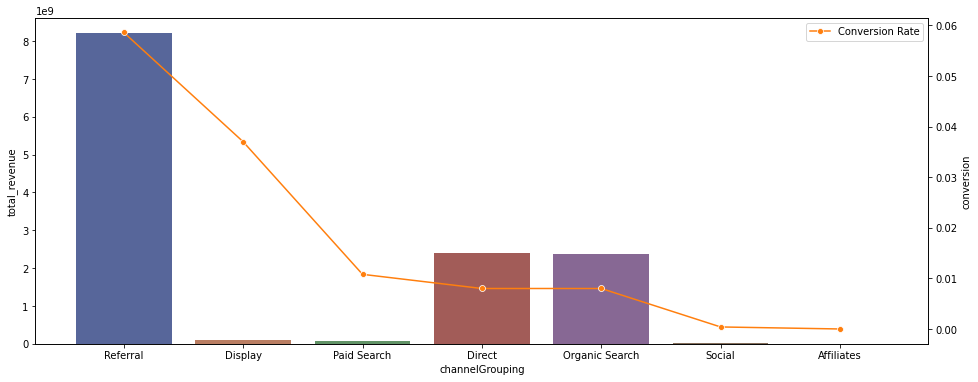

In [23]:
# 6. Which channelGrouping has the highest probability of conversion to purchase?

# plot the conversion rate against different columns, focusing on all the transactions
def plot_conversion_and_revenue(feature_name, sort_by=None, ascending=True, key=None, show_all=True, rotation=0):  
    data = df.groupby(feature_name)['totals.transactionRevenue'].describe().reset_index()
    total_rev = df.groupby(feature_name)['totals.transactionRevenue'].sum()
    value = df[feature_name].value_counts().to_dict() 
    data['total'] = data[feature_name].map(value)
    data['conversion'] = round((data['count']/data['total']),4) # Conversion Rate
    data['total_revenue'] = data[feature_name].map(total_rev) # Total Revenue
    data = data.sort_values(by=sort_by,ascending=ascending,key=key)
    
    if show_all: # Limit the number of x variable if necessary
        data = data
    else: data = data[0:10]

    try:
        data[feature_name] = data[feature_name].astype(str) #avoid x-axis of barplot and lineplot not aligning
    except: pass
    
    fig, ax1 = plt.subplots(figsize=(16,6)) 
    plt.xticks(rotation=rotation)
    sns.barplot(data = data,
                x=feature_name,
                y='total_revenue',
                alpha=0.7,
                ax=ax1,
                palette="dark",label = "Revenue")
    ax2 = ax1.twinx()
    sns.lineplot(data = data
                 ,x=feature_name,
                 y='conversion',
                 ax=ax2,
                 color='tab:orange',
                 marker="o",label = "Conversion Rate")
    
    
plot_conversion_and_revenue('channelGrouping',
                            sort_by='conversion',
                            ascending=False)

# Referral is the highest, followed by Other, Paid Search and Direct
# Organic Search appears the most in the dataset but the conversion rate is not high.
# other is the second highest because the total number of transactions are too few.

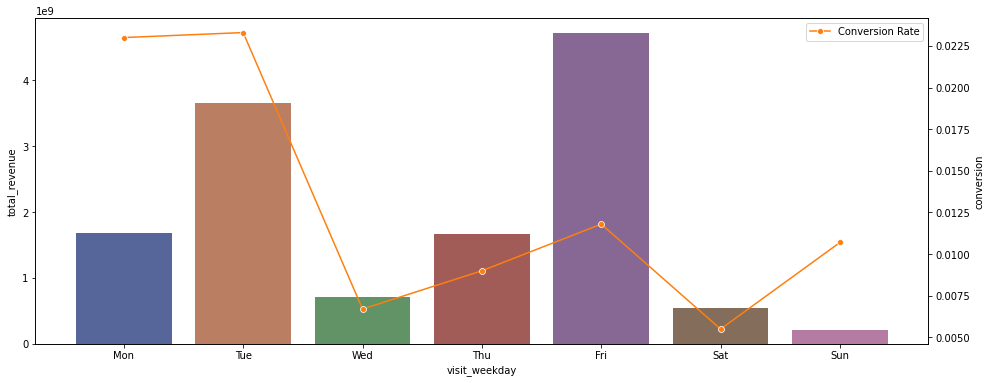

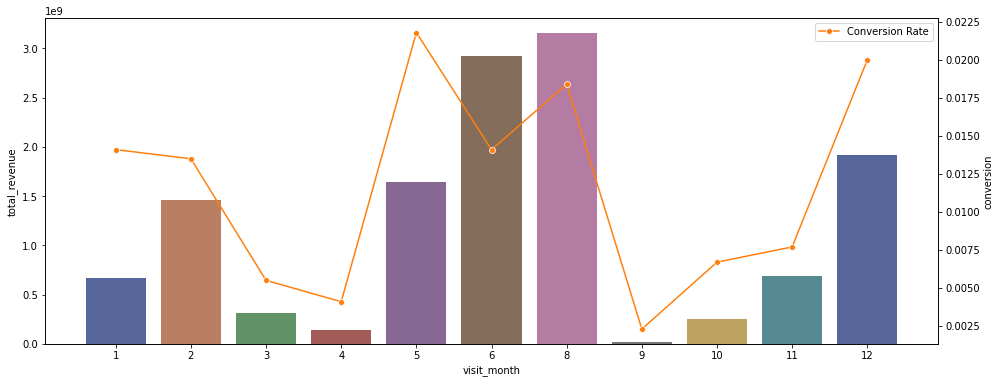

In [24]:
# 7. Any time-series trend in purchase pattern? e.g. which weekday has the highest purchase
# How are date related to the conversion rate?

#,'visit_day','visit_hour'
for date in ['visit_weekday','visit_month']:
    if date == 'visit_weekday':
        key = lambda x:x.map({'Mon':0,'Tue':1,'Wed':2,'Thu':3,'Fri':4,'Sat':5,'Sun':6})
    else: pass
    plot_conversion_and_revenue(date,sort_by=date,ascending=True,key=key)

### Observations:

* Revenue on Sat and Sun drops obviously
* Purchasing pattern observed - April and August have the highest total revenue
* Low transaction volumes in the evening
    * High at mid-night

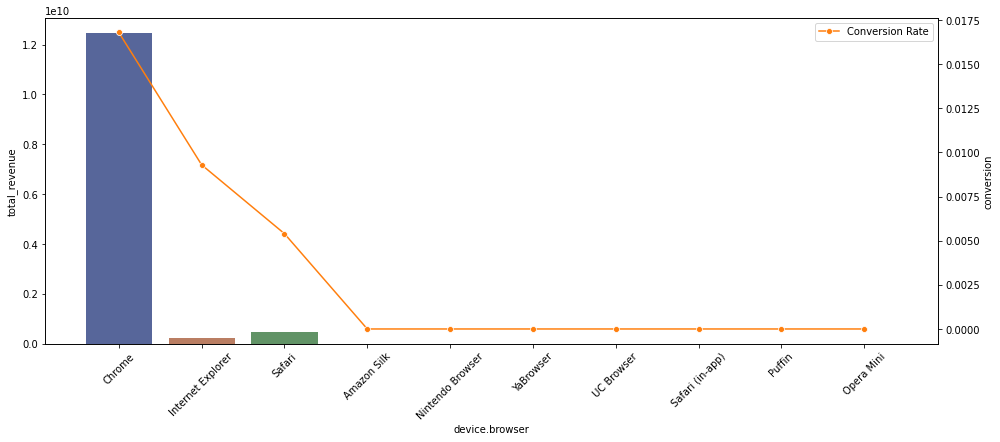

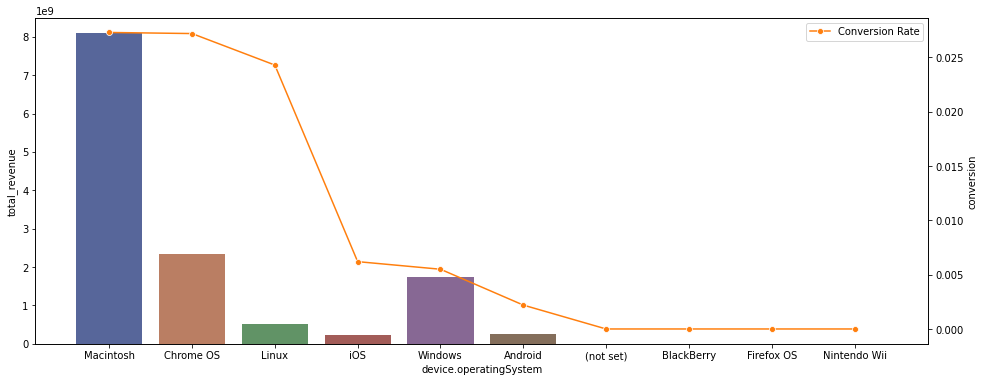

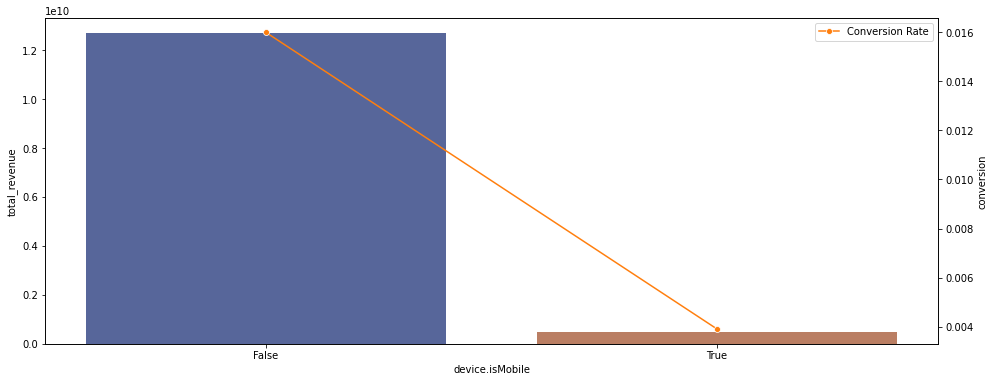

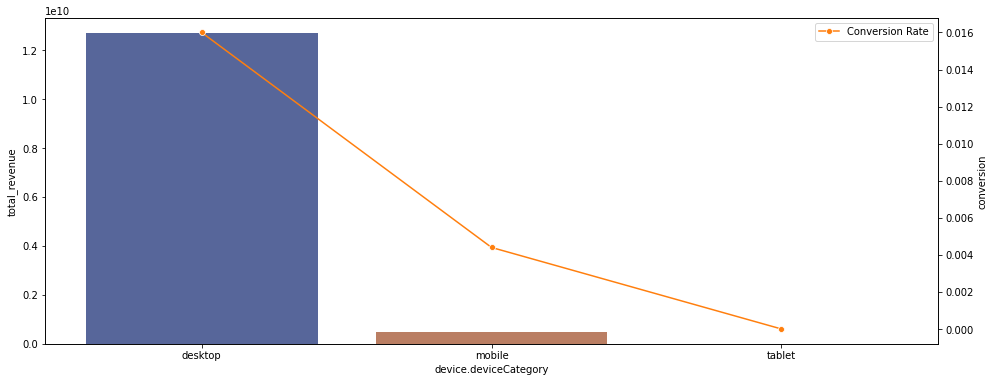

In [25]:
# how device relate to the conversion rate
for i in df.columns:
    if 'device' in i:
        rotation = 45 if 'browser' in i else 0
        plot_conversion_and_revenue(i,sort_by='conversion',ascending=False,rotation=rotation,show_all=False)

### Observations:

* Chrome is the highest
* Chrome OS as well
* When people are not using mobile to visit, the conversion rate is nearly 4 times higher.
    * the transaction volumes whith deciveCategory = tablet is the least.

### How geoNetwork relate to revenue:

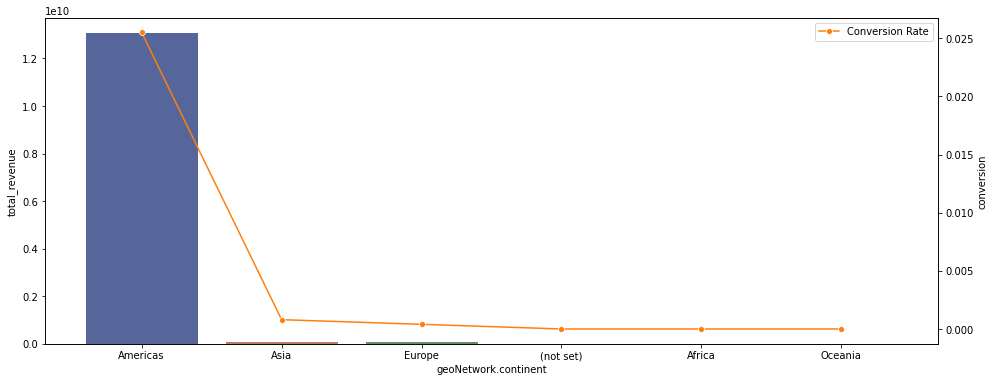

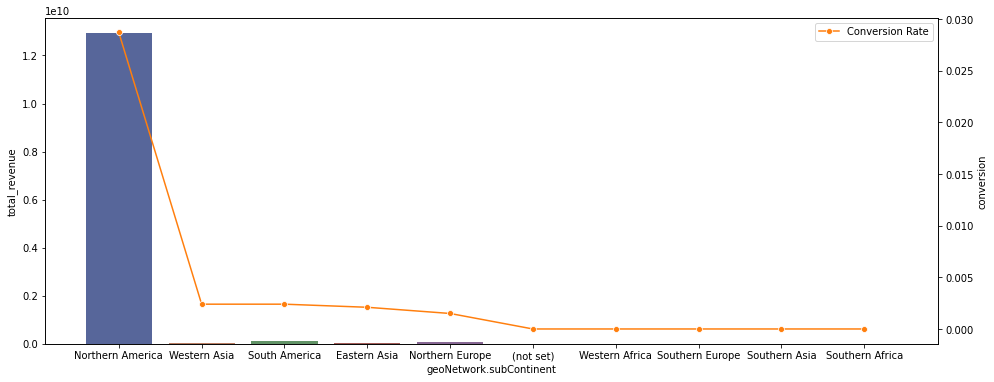

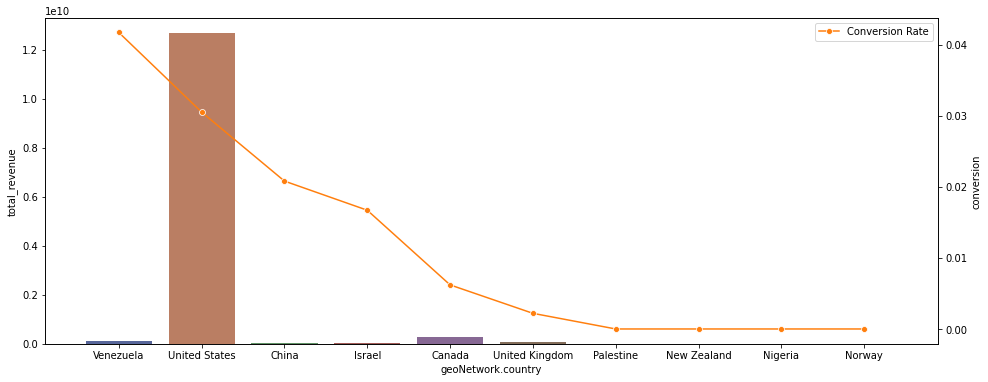

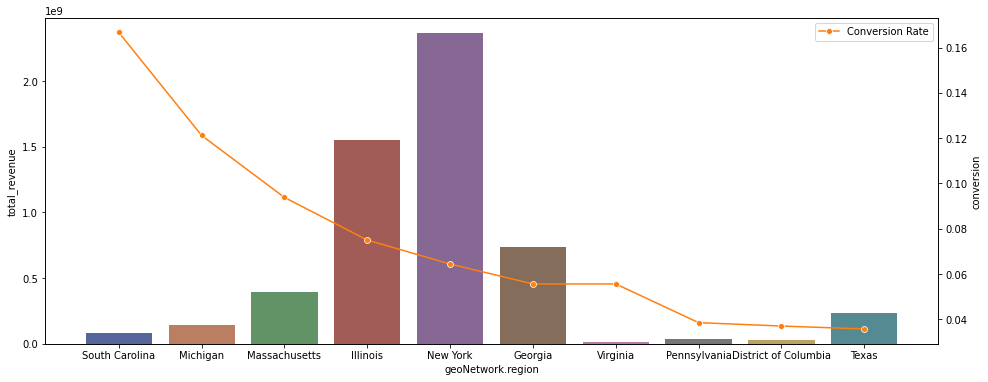

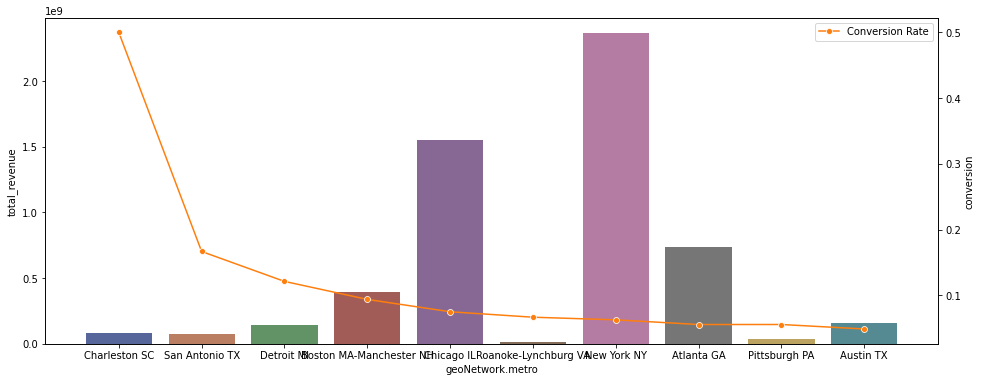

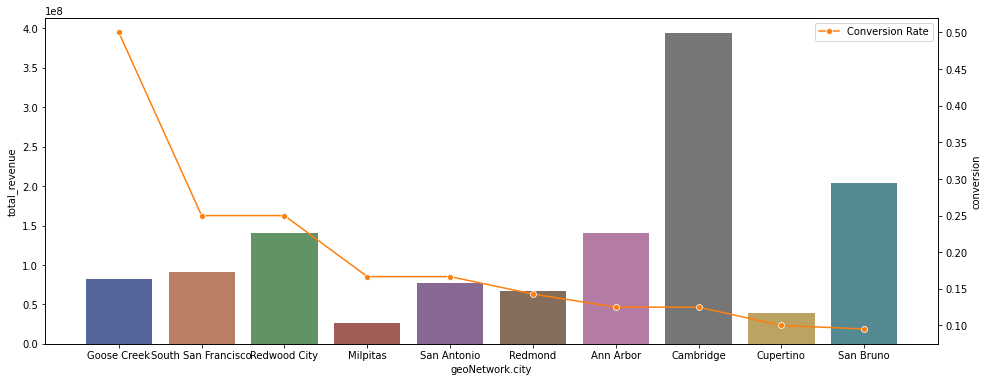

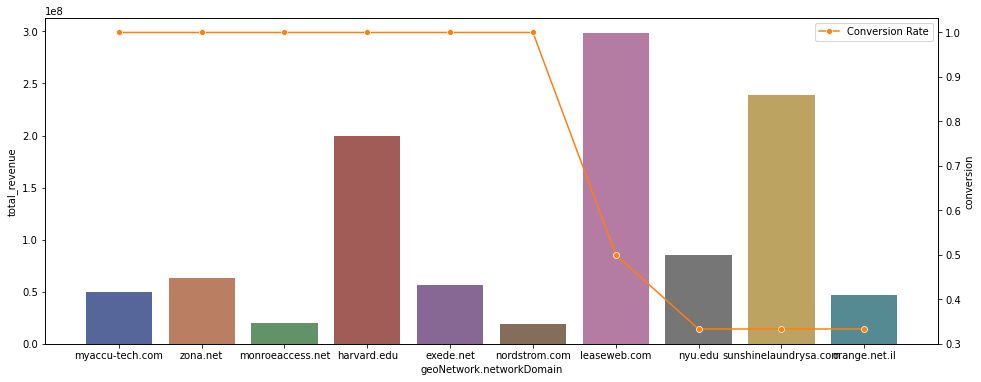

In [26]:

for i in df.columns:
    if 'geoNetwork' in i:
        plot_conversion_and_revenue(i,sort_by='conversion',ascending=False,show_all=False)

In [27]:
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
world=world.filter(items=["name","geometry"])

country = df.groupby('geoNetwork.country')['totals.transactionRevenue'].describe().reset_index()
country=country.filter(items=["geoNetwork.country","count"])
total_rev = df.groupby('geoNetwork.country')['totals.transactionRevenue'].sum()
value = df['geoNetwork.country'].value_counts().to_dict() 

country['total'] = country['geoNetwork.country'].map(value)
country['conversion rate'] = round((country['count']/country['total']),4) # Conversion Rate
country['total_revenue'] = country['geoNetwork.country'].map(total_rev) # Total Revenue
    
country['geoNetwork.country']=country['geoNetwork.country'].\
                                replace(['United States'],'United States of America')

world=world.merge(country.filter(items=["geoNetwork.country",'conversion rate',"total_revenue"]),
                  left_on="name",
                  right_on="geoNetwork.country",
                  how="right")

#world["totals.transactionRevenue"]=world["total_revenue"].fillna(0)
world["log_rev"]=np.log(world["total_revenue"])
world=world.replace([np.inf, -np.inf], np.nan)
world["log_rev"]=world["log_rev"].fillna(0)

<AxesSubplot:>

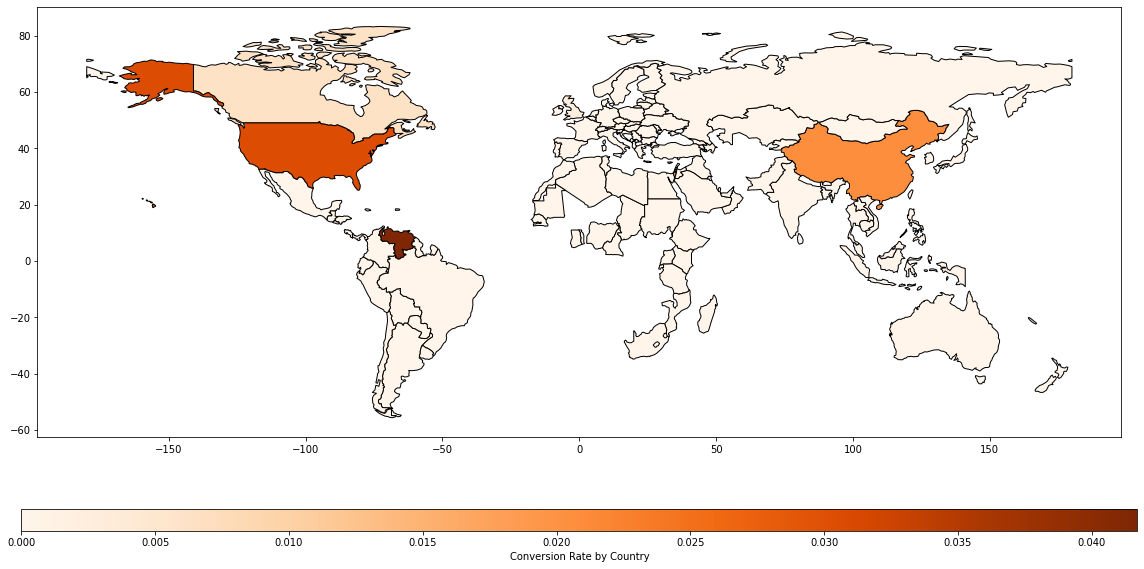

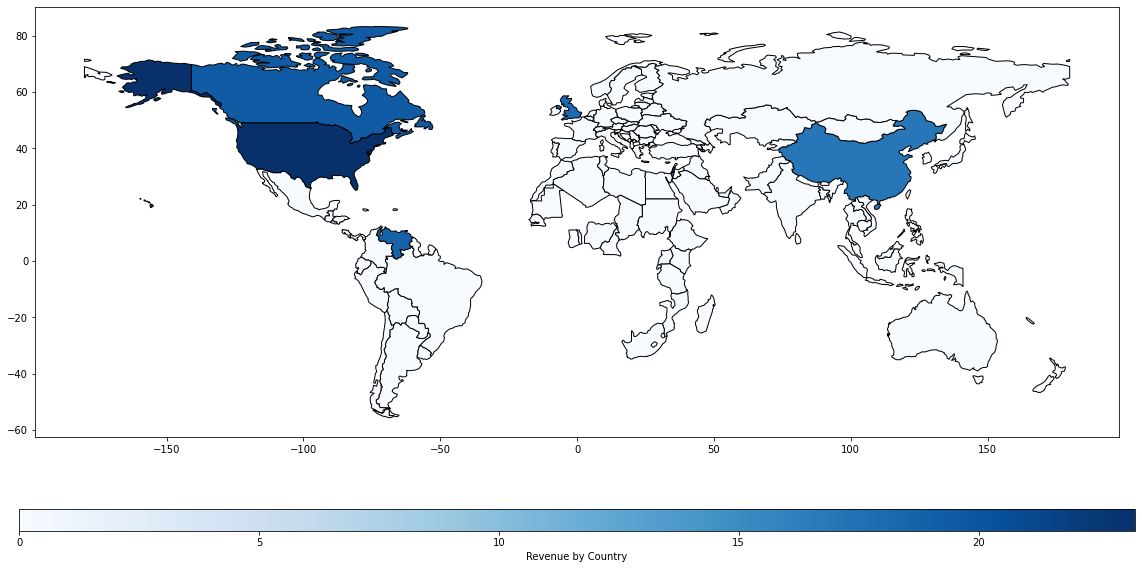

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax1 = plt.subplots(1,1,figsize=(20,20))
divider1 = make_axes_locatable(ax1)
cax1=divider1.append_axes("bottom", size="5%", pad=1)

world.plot(column=world["conversion rate"],
           edgecolor="black",
           ax=ax1,
           cmap='Oranges',
           cax=cax1,
           legend=True,
           legend_kwds={'label':"Conversion Rate by Country",
                        'orientation':"horizontal"},)





fig, ax = plt.subplots(1,1,figsize=(20,20))
divider = make_axes_locatable(ax)
cax=divider.append_axes("bottom", size="5%", pad=1)
world.plot(column=world["log_rev"],
           edgecolor="black",
           ax=ax,
           cmap='Blues',
        figsize=(20,20),
           cax=cax,
           legend=True,
           legend_kwds={'label':"Revenue by Country",
                        'orientation':"horizontal"},)

#new.plot(column=((new["totals.transactionRevenue"])),figsize=(25, 20),legend=True,cmap='rainbow')

### Observations:
* America has the highest conversion rate as well as the total revenue.


# How trafficSource relate to revenue:

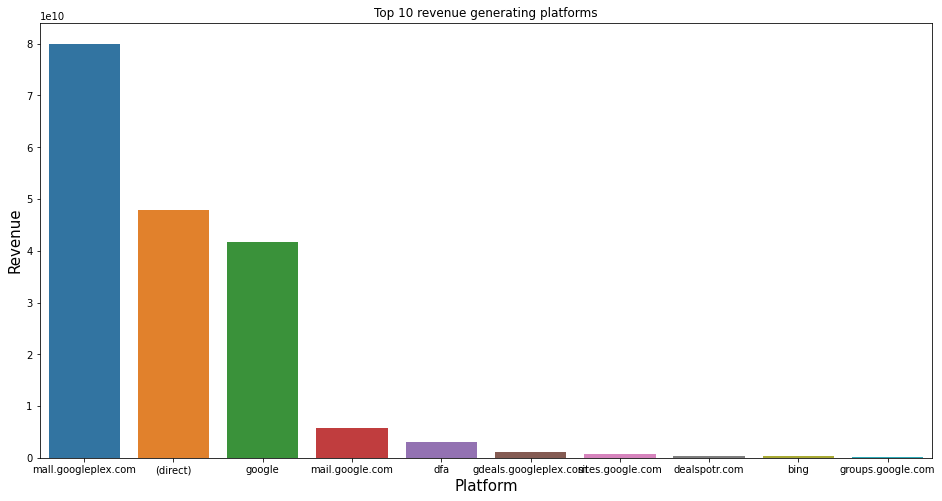

In [29]:
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].astype(float)

x = train.groupby(['trafficSource.source'])['totals.transactionRevenue'].sum().reset_index().sort_values('totals.transactionRevenue', ascending=False).iloc[0:10].iloc[:,0]
y = train.groupby(['trafficSource.source'])['totals.transactionRevenue'].sum().reset_index().sort_values('totals.transactionRevenue', ascending=False).iloc[0:10].iloc[:,1]

plt.figure(figsize = (16,8))
sns.barplot(x, y)

plt.xlabel("Platform", fontsize = 15)
plt.ylabel("Revenue",fontsize = 15)
plt.title("Top 10 revenue generating platforms")
plt.show()

#### Revenue Situation:

In [30]:
print(f"Number of customers creating revenue: {len(train[train['totals.transactionRevenue'] > 0].groupby(['fullVisitorId'])['totals.transactionRevenue'].sum())}")
print(f"Minimum expenditure of customers: {min(train[train['totals.transactionRevenue'] > 0].groupby(['fullVisitorId'])['totals.transactionRevenue'].sum())}")
print(f"Maximum expenditure of customers: {max(train[train['totals.transactionRevenue'] > 0].groupby(['fullVisitorId'])['totals.transactionRevenue'].sum())}")
print(f"Percentage of customers generating revenue: {100*(len(train[train['totals.transactionRevenue'] > 0].groupby(['fullVisitorId'])['totals.transactionRevenue'].sum())/train.fullVisitorId.nunique())}")

Number of customers creating revenue: 1346
Minimum expenditure of customers: 1200000.0
Maximum expenditure of customers: 5770790000.0
Percentage of customers generating revenue: 1.5087487249616087


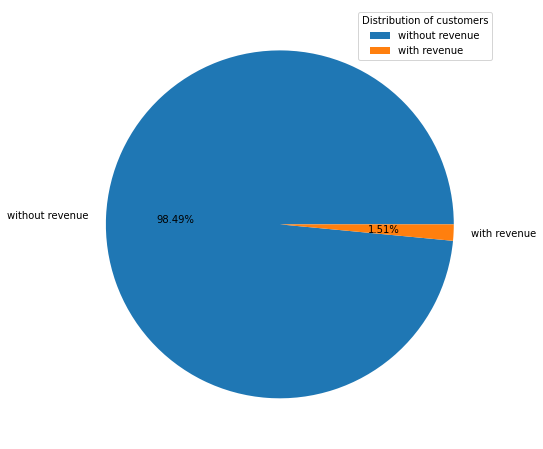

In [31]:
y = np.array([len(train.groupby(['fullVisitorId'])['totals.transactionRevenue'].\
                      sum())-len(train[train['totals.transactionRevenue'] > 0]\
                                 .groupby(['fullVisitorId'])['totals.transactionRevenue'].\
                                 sum()), len(train[train['totals.transactionRevenue'] > 0].\
                                             groupby(['fullVisitorId'])['totals.transactionRevenue'].sum())])
mylabels = ["without revenue","with revenue"]

fig = plt.figure(figsize=[8, 8])
plt.pie(y, labels = mylabels, autopct='%1.2f%%')
plt.legend(title = "Distribution of customers")
plt.show()

### Check missing value:

In [32]:
import missingno as msno

In [33]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()/df.shape[0]

totals.pageviews                        0.000199
totals.bounces                          0.502040
totals.newVisits                        0.232262
totals.transactionRevenue               0.987063
trafficSource.keyword                   0.558364
trafficSource.referralPath              0.636183
trafficSource.adwordsClickInfo.slot     0.976515
trafficSource.adwordsClickInfo.gclId    0.976117
trafficSource.adContent                 0.986566
trafficSource.campaignCode              1.000000
transactionRevenue                      0.987063
dtype: float64

In [34]:
# impute the median
df['totals.pageviews'].fillna(df['totals.pageviews'].median(), inplace = True)
# zero for nan
df['totals.transactionRevenue'].fillna(0, inplace = True)
df['totals.bounces'].fillna(0, inplace = True)
df['totals.newVisits'].fillna(0, inplace = True)

In [35]:
df.dropna(axis=1,how='any',inplace=True)
df.shape

(10049, 30)

In [36]:
df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,visit_month,visit_day,visit_weekday,visit_hour
0,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1,1,1,1,1,0.0,(not set),google,organic,9,2,Fri,1
1,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,1,1,1,0.0,(not set),google,organic,9,2,Fri,5
2,Organic Search,2016-09-02,9499785259412240342,9499785259412240342_1472812272,1472812272,1,Firefox,Windows,False,desktop,Europe,Western Europe,Netherlands,not available in demo dataset,not available in demo dataset,not available in demo dataset,chello.nl,1,1,1,1,1,0.0,(not set),google,organic,9,2,Fri,10
3,Organic Search,2016-09-02,1438082600262726746,1438082600262726746_1472803483,1472803483,1,Safari,iOS,True,mobile,Asia,Southern Asia,Pakistan,Sindh,(not set),Karachi,unknown.unknown,1,1,1,1,1,0.0,(not set),google,organic,9,2,Fri,8
4,Organic Search,2016-09-02,9638207207743070032,9638207207743070032_1472824614,1472824614,1,Chrome,Macintosh,False,desktop,Asia,Eastern Asia,China,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,1,1,1,0.0,(not set),baidu,organic,9,2,Fri,13


 ### Re-formatting

In [37]:
# define useless columns
useless_columns = ['date','sessionId','visitId']

In [38]:
col = ['channelGrouping','geoNetwork.region','geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain', 'trafficSource.campaign','geoNetwork.continent','geoNetwork.subContinent']
#drop continent and sub continent to avoid multicollinearity. We only use country to analyse
#drop channelGrouping to avoid multicollinearity
for i in col:
    print(df[i].value_counts().head(3))
    print('\n')
# The majority of these 5 columns are 'not available' and 'not set'

# Append to useless_columns
useless_columns = useless_columns + col

Organic Search    4235
Social            2360
Direct            1628
Name: channelGrouping, dtype: int64


not available in demo dataset    5497
California                       1303
(not set)                         323
Name: geoNetwork.region, dtype: int64


not available in demo dataset        5497
(not set)                            2321
San Francisco-Oakland-San Jose CA    1184
Name: geoNetwork.metro, dtype: int64


not available in demo dataset    5497
Mountain View                     556
(not set)                         352
Name: geoNetwork.city, dtype: int64


(not set)          2773
unknown.unknown    1594
comcast.net         289
Name: geoNetwork.networkDomain, dtype: int64


(not set)                             9633
Data Share Promo                       171
AW - Dynamic Search Ads Whole Site     138
Name: trafficSource.campaign, dtype: int64


Americas    4981
Asia        2475
Europe      2258
Name: geoNetwork.continent, dtype: int64


Northern America    4387
Southeast 

In [39]:
df.drop(useless_columns,axis=1,inplace=True)
df.shape

(10049, 19)

In [40]:
# Review the nunique of each columns:
for i in df.columns:
    print(f'{i} : {df[i].nunique()} , {df[i].dtype}')

fullVisitorId : 8921 , object
visitNumber : 82 , int64
device.browser : 23 , object
device.operatingSystem : 12 , object
device.isMobile : 2 , bool
device.deviceCategory : 3 , object
geoNetwork.country : 135 , object
totals.visits : 1 , object
totals.hits : 93 , object
totals.pageviews : 76 , object
totals.bounces : 2 , object
totals.newVisits : 2 , object
totals.transactionRevenue : 122 , float64
trafficSource.source : 65 , object
trafficSource.medium : 6 , object
visit_month : 11 , int64
visit_day : 24 , int64
visit_weekday : 7 , object
visit_hour : 24 , int64


In [41]:
# Limit the nunique of geoNetwork.country and trafficSource.source 

top_50 = df['geoNetwork.country'].value_counts()[0:50].index

df['geoNetwork.country'] = df['geoNetwork.country']\
    .map(lambda x:x if x in top_50 else 'Others')
top_10 = df['trafficSource.source'].value_counts()[0:10].index
df['trafficSource.source'] = df['trafficSource.source']\
    .map(lambda x:x if x in top_10 else 'Others')

#### 3.2 Encoding and Aggregation:

In [42]:
df.head()

,fullVisitorId,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.country,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.source,trafficSource.medium,visit_month,visit_day,visit_weekday,visit_hour
0,3895546263509774583,1,Chrome,Windows,False,desktop,Spain,1,1,1,1,1,0.0,google,organic,9,2,Fri,1
1,4763447161404445595,1,UC Browser,Linux,False,desktop,Indonesia,1,1,1,1,1,0.0,google,organic,9,2,Fri,5
2,9499785259412240342,1,Firefox,Windows,False,desktop,Netherlands,1,1,1,1,1,0.0,google,organic,9,2,Fri,10
3,1438082600262726746,1,Safari,iOS,True,mobile,Pakistan,1,1,1,1,1,0.0,google,organic,9,2,Fri,8
4,9638207207743070032,1,Chrome,Macintosh,False,desktop,China,1,1,1,1,1,0.0,baidu,organic,9,2,Fri,13


In [43]:
# change the dtype
for category in ['device.browser','device.operatingSystem','device.deviceCategory',
                 'geoNetwork.country','trafficSource.source',
                 'trafficSource.medium','visit_weekday','device.isMobile']:
    df[category] = df[category].astype('category')

for numeric in ['totals.hits','visitNumber','visit_month','visit_day','visit_hour',
                'totals.pageviews','totals.bounces','totals.newVisits','totals.visits'
                ,'totals.transactionRevenue']:
    df[numeric] = df[numeric].astype('int')

In [44]:
for feature in [category for category in df.columns if df[category].dtype.name == 'category']:
    label_encoder = preprocessing.LabelEncoder() 
    label_encoder.fit(list(df[feature].values.astype('str')))
    df[feature] = label_encoder.transform(list(df[feature].values.astype('str'))) 
df.head()

,fullVisitorId,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.country,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.source,trafficSource.medium,visit_month,visit_day,visit_weekday,visit_hour
0,3895546263509774583,1,4,8,0,0,39,1,1,1,1,1,0,6,4,9,2,0,1
1,4763447161404445595,1,20,5,0,0,17,1,1,1,1,1,0,6,4,9,2,0,5
2,9499785259412240342,1,7,8,0,0,25,1,1,1,1,1,0,6,4,9,2,0,10
3,1438082600262726746,1,18,11,1,1,28,1,1,1,1,1,0,6,4,9,2,0,8
4,9638207207743070032,1,4,6,0,0,6,1,1,1,1,1,0,4,4,9,2,0,13


In [45]:
df.dtypes

fullVisitorId                object
visitNumber                   int64
device.browser                int64
device.operatingSystem        int64
device.isMobile               int64
device.deviceCategory         int64
geoNetwork.country            int64
totals.visits                 int64
totals.hits                   int64
totals.pageviews              int64
totals.bounces                int64
totals.newVisits              int64
totals.transactionRevenue     int64
trafficSource.source          int64
trafficSource.medium          int64
visit_month                   int64
visit_day                     int64
visit_weekday                 int64
visit_hour                    int64
dtype: object

In [46]:
# Aggregate the data at user level
df_grouped = df.groupby('fullVisitorId').agg({
                        #Categorical data - extract the most frequent value 
                        'device.browser':[('browser',lambda x:x.value_counts().index[0])],
                        'device.operatingSystem':[('operatingSystem',lambda x:x.value_counts().index[0])],
                        'device.isMobile':[('isMobile',lambda x:x.value_counts().index[0])],
                        'device.deviceCategory':[('deviceCategory',lambda x:x.value_counts().index[0])],
                        'geoNetwork.country':[('country',lambda x:x.value_counts().index[0])],
                        'trafficSource.source':[('source',lambda x:x.value_counts().index[0])],
                        'trafficSource.medium':[('medium',lambda x:x.value_counts().index[0])],
                        'visit_weekday':[('weekday',lambda x:x.value_counts().index[0])],
                        'visit_month':[('month',lambda x:x.value_counts().index[0])],
                        'visit_day':[('day',lambda x:x.value_counts().index[0])],
                        'visit_hour':[('hour',lambda x:x.value_counts().index[0])],
                        # Numeric data - extract min, max, sum and mean
                        'visitNumber':[('visNum_max',lambda x:x.max()),
                                       ('visNum_min',lambda x:x.min()),
                                       ('visNum_sum',lambda x:x.sum()),
                                       ('visNum_mean',lambda x:x.mean())],
                        'totals.visits':[('visit_max',lambda x:x.max()),
                                         ('visit_min',lambda x:x.min()),
                                         ('visit_sum',lambda x:x.sum()),
                                         ('visit_mean',lambda x:x.mean())],
                        'totals.hits':[('hits_max',lambda x:x.max()),
                                       ('hits_min',lambda x:x.min()),
                                       ('hits_sum',lambda x:x.sum()),
                                       ('hits_mean',lambda x:x.mean())],
                        'totals.pageviews':[('pageviews_max',lambda x:x.max()),
                                            ('pageviews_min',lambda x:x.min()),
                                            ('pageviews_sum',lambda x:x.sum()),
                                            ('pageviews_mean',lambda x:x.mean())],
                        'totals.bounces':[('bounces_max',lambda x:x.max()),
                                          ('bounces_min',lambda x:x.min()),
                                          ('bounces_sum',lambda x:x.sum()),
                                          ('bounces_mean',lambda x:x.mean())],
                        'totals.newVisits':[('newVisits_max',lambda x:x.max()),
                                            ('newVisits_min',lambda x:x.min()),
                                            ('newVisits_sum',lambda x:x.sum()),
                                            ('newVisits_mean',lambda x:x.mean())],
                        'totals.transactionRevenue' :[('transactionRevenue_sum',lambda x:x.sum())]})

df_grouped.columns = df_grouped.columns.droplevel() 
df_grouped.head(5)

,browser,operatingSystem,isMobile,deviceCategory,country,source,medium,weekday,month,day,hour,visNum_max,visNum_min,visNum_sum,visNum_mean,visit_max,visit_min,visit_sum,visit_mean,hits_max,hits_min,hits_sum,hits_mean,pageviews_max,pageviews_min,pageviews_sum,pageviews_mean,bounces_max,bounces_min,bounces_sum,bounces_mean,newVisits_max,newVisits_min,newVisits_sum,newVisits_mean,transactionRevenue_sum
fullVisitorId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000702913088027926,4,11,1,1,27,6,4,2,3,18,3,3,1,6,2.0,1,1,3,1,4,1,7,2.333333,4,1,7,2.333333,1,0,1,0.333333,1,0,1,0.333333,0
0001156383977201253,18,11,1,2,20,6,4,4,11,10,21,1,1,1,1.0,1,1,1,1,1,1,1,1.000000,1,1,1,1.000000,1,1,1,1.000000,1,1,1,1.000000,0
0001363886612345162,4,8,0,0,29,10,5,2,9,17,18,4,4,4,4.0,1,1,1,1,1,1,1,1.000000,1,1,1,1.000000,1,1,1,1.000000,0,0,0,0.000000,0
0002746729524999850,4,8,0,0,26,6,4,0,12,16,23,1,1,1,1.0,1,1,1,1,1,1,1,1.000000,1,1,1,1.000000,1,1,1,1.000000,1,1,1,1.000000,0
0003303233290293331,18,11,1,1,40,6,4,4,4,20,19,1,1,1,1.0,1,1,1,1,37,37,37,37.000000,32,32,32,32.000000,0,0,0,0.000000,1,1,1,1.000000,0


# 4. Modelling and Evaluation

In [47]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

dataset = df_grouped
dataset['target_variable'] = dataset['transactionRevenue_sum'].map(np.log1p)

In [48]:
# Using all features
X = dataset.drop(['target_variable','transactionRevenue_sum'],axis=1)
# Only 5 features
# X = dataset[['visit_sum','hits_sum','pageviews_sum','bounces_sum','newVisits_sum']]

y = dataset['target_variable']
y = np.log1p(y)

In [49]:
# train test split - 80% training set and 20% test set
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [50]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()

model_lr.fit(train_X, train_y)

prediction = model_lr.predict(test_X)

#reverse of natural log
reversed_prediction = np.expm1(prediction)

sum_value = pd.Series(index = test_X.index,
                      data = reversed_prediction)

#rmse
mean_squared_error(np.expm1(test_y), sum_value,squared=False)


2.463415551531386

# Decision Tree

In [51]:
from sklearn.tree import DecisionTreeRegressor
model_dt=DecisionTreeRegressor(max_depth=30)
model_dt.fit(train_X,train_y)

DecisionTreeRegressor(max_depth=30)

In [52]:
prediction = model_dt.predict(test_X)

#reverse of natural log
reversed_prediction = np.expm1(prediction)

sum_value = pd.Series(index = test_X.index, 
                      data = reversed_prediction)

mean_squared_error(np.expm1(test_y), sum_value,squared=False)

2.7093859674075165

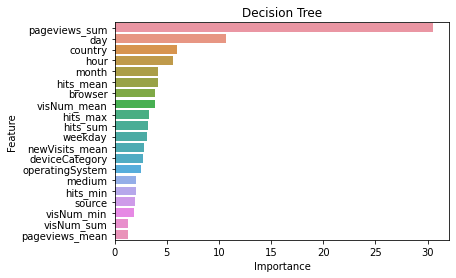

In [53]:
def freature_important_plot(model,
                            n_freature:int
                            ,title:str):
    featureImp= []
    for feat, importance in zip(train_X.columns, model.feature_importances_):  
        temp = [feat, importance*100]
        featureImp.append(temp)
    model_df = pd.DataFrame(featureImp,columns = ['Feature', 'Importance']).\
    sort_values('Importance', ascending = False).head(n_freature)
    sns.barplot(x=model_df['Importance'], y=model_df['Feature'])
    plt.title(title)
    

freature_important_plot(model_dt,20,"Decision Tree")


# Random Forest

In [54]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(random_state = 42)

In [55]:
model_rf.fit(train_X,train_y)
model_rf.score(train_X, train_y)

0.8886828341532201

In [56]:
model_rf.score(test_X, test_y)

0.38252431880915205

In [57]:
prediction = model_rf.predict(test_X)

#reverse of natural log
reversed_prediction = np.expm1(prediction)
sum_value = pd.Series(index = test_X.index, data = reversed_prediction)

In [58]:
mean_squared_error(np.expm1(test_y), sum_value,squared=False)

2.186579121880071

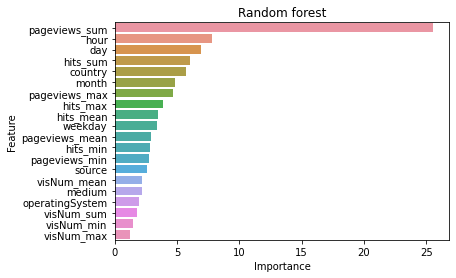

In [59]:
freature_important_plot(model_rf,20,"Random forest")

# XGBoost


In [60]:
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

In [61]:
model_xgb = xgboost.XGBRegressor()
model_xgb.fit(train_X, train_y)
mean_squared_error(np.expm1(test_y), sum_value,squared=False)


2.186579121880071

In [62]:
model_xgb.score(train_X, train_y)

0.9990480923430224

In [63]:
model_xgb.score(test_X, test_y)

0.318212140530887

In [64]:
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

In [65]:
#Hyperparameter Tuning

#param_tuning = {
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [3, 5, 7, 10],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.5, 0.7],
#     'colsample_bytree': [0.5, 0.7],
#     'n_estimators' : [100, 200, 500],
#     'objective': ['reg:squarederror']
#     }
#model_xgb = XGBRegressor()

#gsearch = GridSearchCV(estimator = model_xgb,
                         #param_grid = param_tuning,                        
                         #cv = 5,
                         #n_jobs = -1,
                         #verbose = 1)
#gsearch.fit(train_X, train_y)
#gsearch.best_params_


In [66]:
# Obtain the parameter after tuning above
par = {'colsample_bytree': 0.7,
     'learning_rate': 0.01,
     'max_depth': 5,
     'min_child_weight': 3,
     'n_estimators': 500,
     'objective': 'reg:squarederror',
     'subsample': 0.7}

model_xgb_T = XGBRegressor(**par)
model_xgb_T.fit(train_X,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
mean_squared_error(np.expm1(test_y), sum_value,squared=False)

2.186579121880071

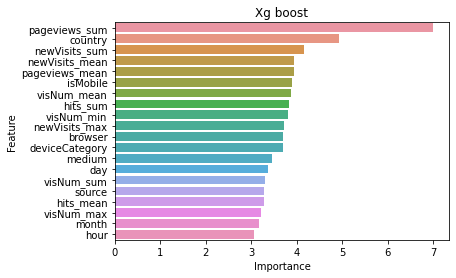

In [68]:
freature_important_plot(model_xgb_T,20,"Xg boost")

In [69]:
model_xgb_T.score(train_X, train_y)

0.7415224665504094

In [70]:
model_xgb_T.score(test_X, test_y)

0.4189169546816712

### Hypertuning:Random Forest

In [71]:
from pprint import pprint

In [72]:
pprint(model_rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [73]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = max_depth = [int(x) for x in np.linspace(5, 200, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 24, 44, 63, 83, 102, 122, 141, 161, 180, 200, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [74]:
## Use the random grid to search for best hyperparameters
## First create the base model to tune
## Random search of parameters, using 3 fold cross validation, 
## search across 100 different combinations, and use all available cores


# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator = rf,
                               #param_distributions = random_grid,
                               #n_iter = 100, 
                               #cv = 3,
                               #verbose=2, 
                               #random_state=42, 
                               #n_jobs = -1)
# Fit the random search model
#rf_random.fit(train_X, train_y)

In [75]:
#best_grid_rf=rf_random.best_params_
#best_grid_rf

In [76]:
# Obtain the parameter after tuning above
bestRF=RandomForestRegressor(max_depth=110, max_features=12, min_samples_leaf=5,
                      min_samples_split=11, n_estimators=300)
bestRF.fit(train_X,train_y)

RandomForestRegressor(max_depth=110, max_features=12, min_samples_leaf=5,
                      min_samples_split=11, n_estimators=300)

In [77]:
scores = cross_val_score(bestRF,
                         train_X,
                         train_y,
                         scoring="r2",
                         cv=cv)
y_pred = model_xgb.predict(train_X)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
rmse = round(np.sqrt(metrics.mean_squared_error(train_y, y_pred)),2)

0.27 accuracy with a standard deviation of 0.04


In [78]:
# compare the model result:
R2score_df=pd.DataFrame({'train':[bestRF.score(train_X, train_y)],'test':[bestRF.score(test_X, test_y)]}, index = ['Random Forest_tune'])


R2score_df =R2score_df.append(pd.DataFrame({'train':[model_rf.score(train_X, train_y)],
                                                'test':[model_rf.score(test_X,test_y)]}
                                                       ,index = ['Random Forest_not_tune']))
                                                                        
R2score_df=R2score_df.append(pd.DataFrame({'train':[model_xgb_T.score(train_X, train_y)],
                                                'test':[model_xgb_T.score(test_X,test_y)]}
                                                       ,index = ['XGboost_tune']))

R2score_df=R2score_df.append(pd.DataFrame({'train':[model_xgb.score(train_X, train_y)],
                                                'test':[model_xgb.score(test_X,test_y)]}
                                                       ,index = ['XGboost_not_tune']))

R2score_df

,train,test
Random Forest_tune,0.578764,0.406075
Random Forest_not_tune,0.888683,0.382524
XGboost_tune,0.741522,0.418917
XGboost_not_tune,0.999048,0.318212


In [79]:
# Predict
y_pred = bestRF.predict(test_X)
# Metrics
r2 = round(metrics.r2_score(test_y, y_pred),4)
rmse = round(np.sqrt(metrics.mean_squared_error(test_y, y_pred)),4)
scores = cross_val_score(bestRF, train_X, train_y, scoring="r2", cv=cv)
pd.DataFrame({'r2':[r2],'rmse':[rmse],'cv_score':[scores.mean()]}, index = ['Random Forest_turned'])

,r2,rmse,cv_score
Random Forest_turned,0.4061,0.3133,0.266459


In [80]:
# Predict
y_pred = model_rf.predict(test_X)
# Metrics
r2 = round(metrics.r2_score(test_y, y_pred),4)
rmse = round(np.sqrt(metrics.mean_squared_error(test_y, y_pred)),4)
scores = cross_val_score(bestRF, train_X, train_y,
                         scoring="r2", cv=cv)
pd.DataFrame({'r2':[r2],'rmse':[rmse],'cv_score':[scores.mean()]}, index = ['Random Forest_not_turned'])


,r2,rmse,cv_score
Random Forest_not_turned,0.3825,0.3194,0.265744


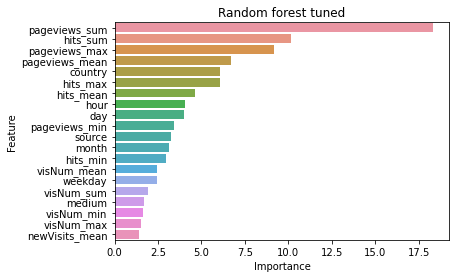

In [81]:
freature_important_plot(bestRF,20,"Random forest tuned")